In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm

In [28]:
#전처리한 데이터들 불러오기.
DATA_IN_PATH = '../../../big_data_sample/pbl/with_soa/'
DATA_OUT_PATH = '../../../big_data_sample/pbl/with_soa/data_out/' 
TRAIN_INPUT_DATA = 'real_train_input.npy'
TRAIN_LABEL_DATA = 'real_train_label.npy'
DATA_CONFIGS = 'real_data_configs.json'

train_input = np.load(open(DATA_OUT_PATH + TRAIN_INPUT_DATA, 'rb'))
train_input = pad_sequences(train_input, maxlen=train_input.shape[1])
train_label = np.load(open(DATA_OUT_PATH + TRAIN_LABEL_DATA, 'rb'))
#prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))
prepro_configs = json.load(open(DATA_OUT_PATH + DATA_CONFIGS, 'rt', encoding='UTF8'))

<h1>시각화 함수 </h1>

In [29]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

<h1>모델 선언 및 컴파일 </h1>

In [30]:
model_name = 'real_classifier_kr'
BATCH_SIZE = 512
NUM_EPOCHS = 10
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension':1}

In [31]:
class CNNClassifier(tf.keras.Model):
    
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                   kernel_size=kernel_size,
                                   padding='valid',
                                   activation=tf.keras.activations.relu,
                                   kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                     for kernel_size in [3,4,5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                           activation=tf.keras.activations.relu,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid,
                           kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list], axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

In [32]:
model = CNNClassifier(**kargs)

model.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.BinaryCrossentropy(),
             metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

In [33]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

../../../big_data_sample/pbl/with_soa/data_out/real_classifier_kr -- Folder already exists 



In [34]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/10
12/12 [==============================] - 3s 201ms/step - loss: 0.6736 - accuracy: 0.6038 - val_loss: 0.8347 - val_accuracy: 0.0000e+00

Epoch 00001: val_accuracy improved from -inf to 0.00000, saving model to ../../../big_data_sample/pbl/with_soa/data_out/real_classifier_kr\weights.h5
Epoch 2/10
12/12 [==============================] - 2s 189ms/step - loss: 0.5747 - accuracy: 0.7186 - val_loss: 0.7350 - val_accuracy: 0.5438

Epoch 00002: val_accuracy improved from 0.00000 to 0.54378, saving model to ../../../big_data_sample/pbl/with_soa/data_out/real_classifier_kr\weights.h5
Epoch 3/10
12/12 [==============================] - 2s 187ms/step - loss: 0.3033 - accuracy: 0.8884 - val_loss: 0.3206 - val_accuracy: 0.8894

Epoch 00003: val_accuracy improved from 0.54378 to 0.88940, saving model to ../../../big_data_sample/pbl/with_soa/data_out/real_classifier_kr\weights.h5
Epoch 4/10
12/12 [==============================] - 2s 191ms/step - loss: 0.0998 - accuracy: 0.9706 - val_loss:

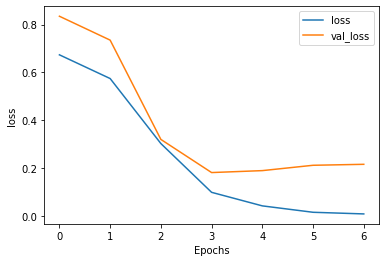

In [35]:
plot_graphs(history, 'loss')

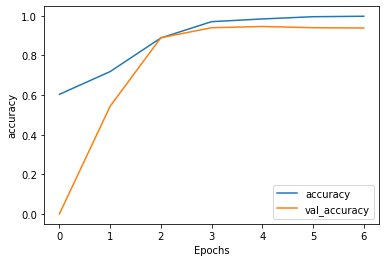

In [36]:
plot_graphs(history, 'accuracy')

<h2>모델 테스트<h2>

In [37]:
DF_TEST_DATA = 'real_test_input.npy'
DF_TEST_LABEL = 'real_test_label.npy'
SAVE_FILE_NM = 'weights.h5' #저장된 best model 이름

test_input = np.load(open(DATA_OUT_PATH + DF_TEST_DATA, 'rb'))
test_input = pad_sequences(test_input, maxlen=test_input.shape[1])
test_label_data = np.load(open(DATA_OUT_PATH + DF_TEST_LABEL , 'rb'))

In [38]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NM))

In [39]:
model.evaluate(test_input, test_label_data)

204/204 [==============================] - 1s 4ms/step - loss: 0.1852 - accuracy: 0.9396


[0.18518629670143127, 0.9395942091941833]